In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.decomposition import PCA, KernelPCA
from megaman.embedding import LocallyLinearEmbedding, Isomap, LTSA
from megaman.geometry import Geometry

import numpy as np

%run ../src/coil20_utils.py

## Loading data

In [2]:
all_imgs = load_images()
all_labels = np.arange(0, 1440, dtype=int) // 72

all_imgs.shape

(1440, 16384)

In [3]:
from sklearn.preprocessing import Normalizer 

imgs = Normalizer().fit_transform(
  all_imgs[:720:6, :])
labels = all_labels[:720:6]

label_names = np.array([
  'duck',
  'wedge',
  'car',
  'kitty',
  'box',
  'sports car',
  'wood brick',
  'bottle',
  'box',
  'vaseline'
])

/opt/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


## Display couple of images

Dataset consists of images of rotated objects.

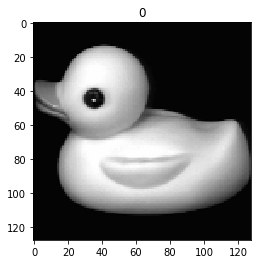

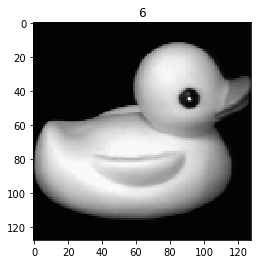

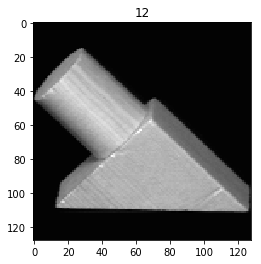

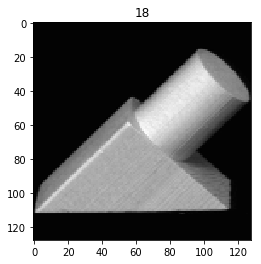

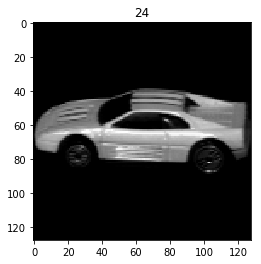

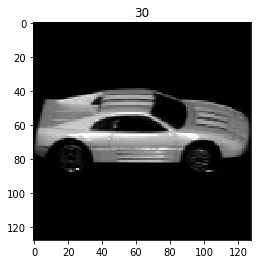

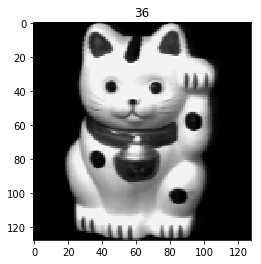

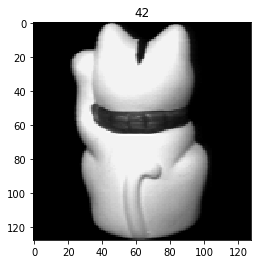

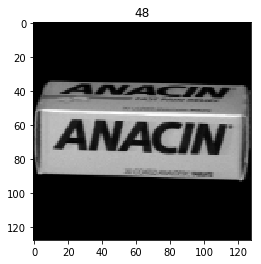

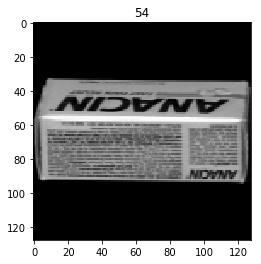

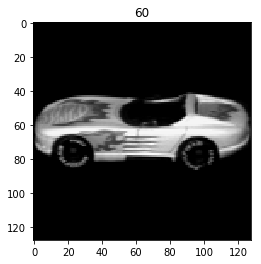

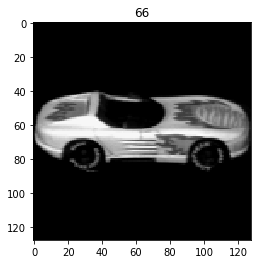

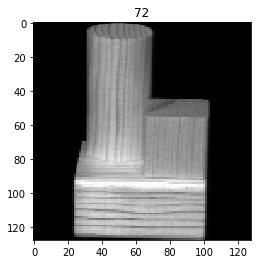

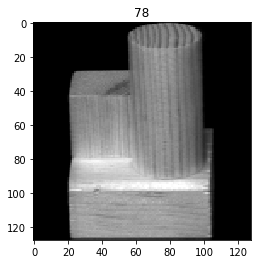

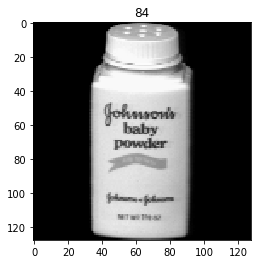

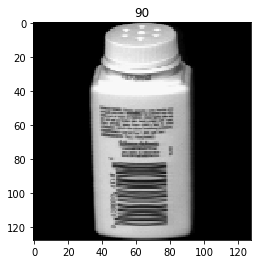

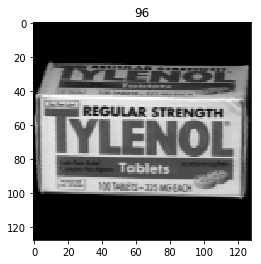

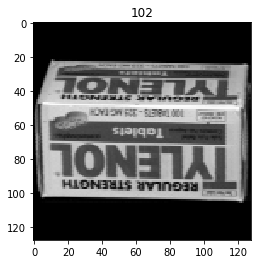

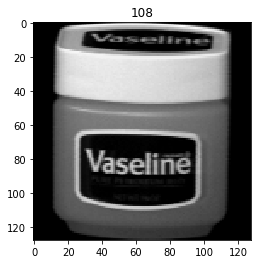

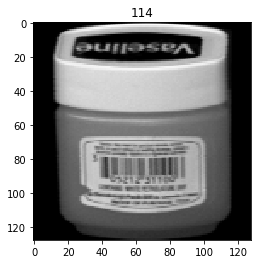

In [4]:

for i in range(0, 120, 6):
  plt.title(i)
  display_image(imgs[i, :], cmap='gray')
  

## PCA 

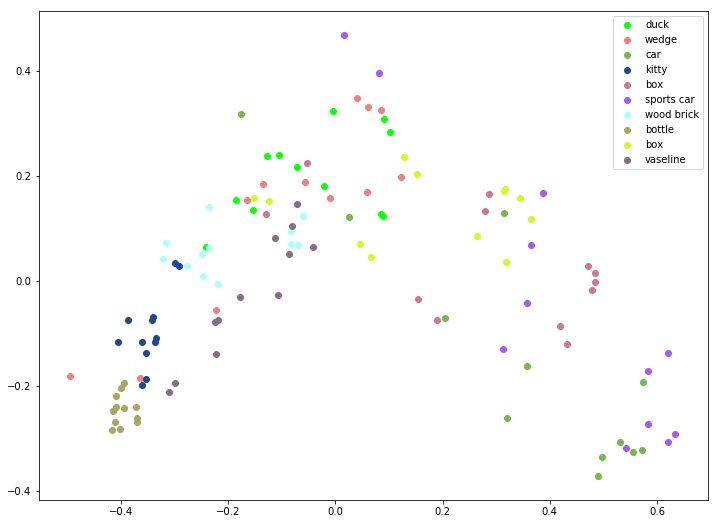

In [5]:
pca = PCA()

imgs_pca = pca.fit_transform(imgs)

rec_error = (np.linalg.norm(
  pca.inverse_transform(imgs_pca) -
  imgs))

plt.figure(figsize=(12,9))
signed_scatterplot(imgs_pca, labels, label_names)
plt.show()

In [6]:
# utility to train over a range of parameters

def train_reducers(reducer_class, lo, hi):
  def train_reducers_generator():
    for i in range(lo, hi):
      geom = Geometry(adjacency_kwds=dict(n_neighbors=i))
      reducer = reducer_class(geom=geom).fit(imgs)
      yield i, reducer
  return dict(train_reducers_generator())

def plot_results(reducers):
  ax = plt.figure(figsize=(9,6))
  rng = sorted(list(reducers.keys()))
  errs = [reducers[i][1] for i in rng]
  plt.plot(rng, errs)
  plt.xlabel('n_neighbors')
  plt.ylabel('reconstruction error')
  plt.show()

## Locally Linear Embedding (LLE)

In [7]:
%time lles = train_reducers(\
  LocallyLinearEmbedding,\
  lo=3, hi=15)

CPU times: user 9.6 s, sys: 3.09 s, total: 12.7 s
Wall time: 9.11 s


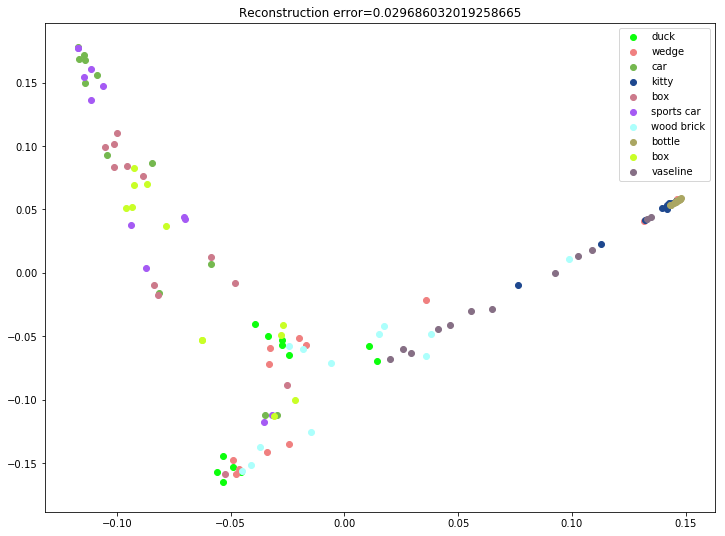

In [8]:
lle = lles[13]
imgs_lle = lle.fit_transform(imgs)

plt.figure(figsize=(12,9))
plt.title('Reconstruction error={}'.format(lle.error_))
signed_scatterplot(imgs_lle, labels, label_names)
plt.show()

## Plot with  edges between adjacent rotated objects

For example embeddings of these two images are joined with edge

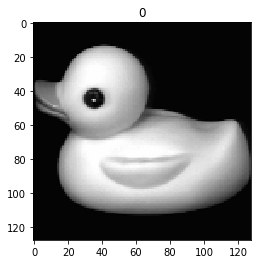

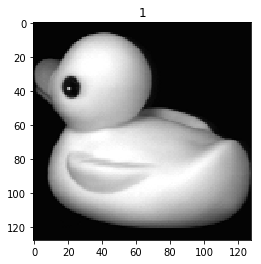

In [9]:
for i in range(0, 2):
  plt.title(i)
  display_image(imgs[i, :], cmap='gray')
  

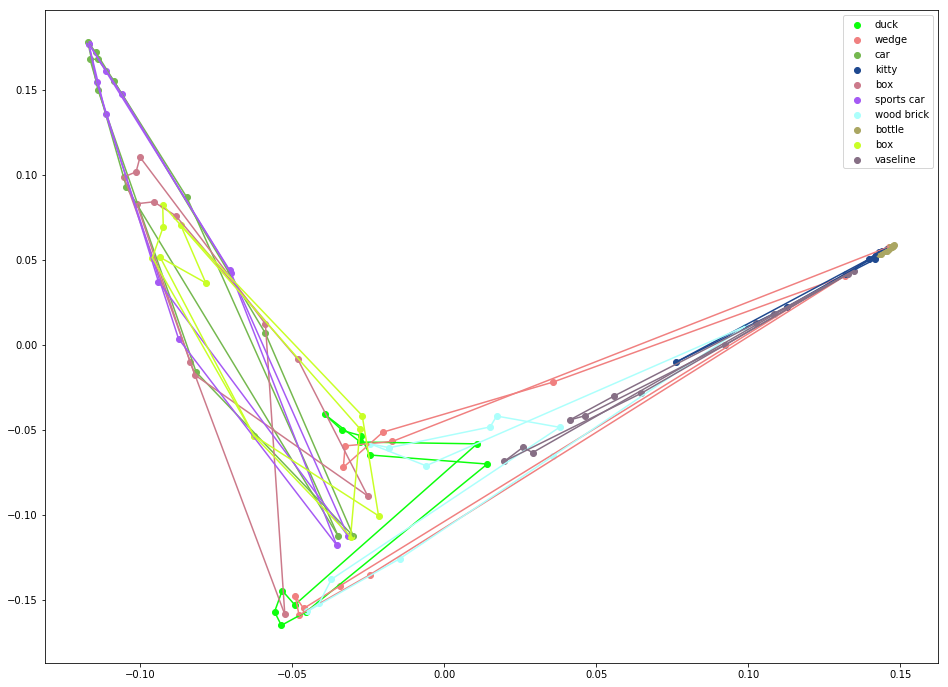

In [10]:
plt.figure(figsize=(16,12))

rotation_trajectories_scatterplot(imgs_lle, labels, label_names)
plt.show()

## Isomap

In [11]:
isomap = Isomap(geom=Geometry(adjacency_kwds=dict(n_neighbors=15)))
imgs_isomap = isomap.fit_transform(imgs)


In [12]:
%time isomaps = dict(train_reducers(Isomap, lo=9, hi=25))

CPU times: user 10.5 s, sys: 4.36 s, total: 14.9 s
Wall time: 9.87 s


In [13]:
isomap = isomaps[19]
%time imgs_isomap = isomap.fit_transform(imgs)

CPU times: user 12 ms, sys: 40 ms, total: 52 ms
Wall time: 14.9 ms


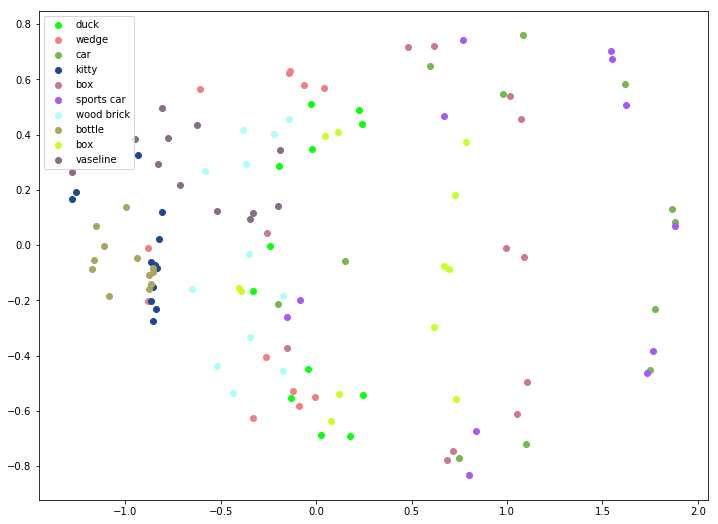

In [14]:
plt.figure(figsize=(12, 9))
#plt.title('Reconstruction error={}'.format(isomap.reconstruction_error()))

signed_scatterplot(imgs_isomap, labels, label_names)
plt.show()

## Plot with  edges between adjacent rotations of objects

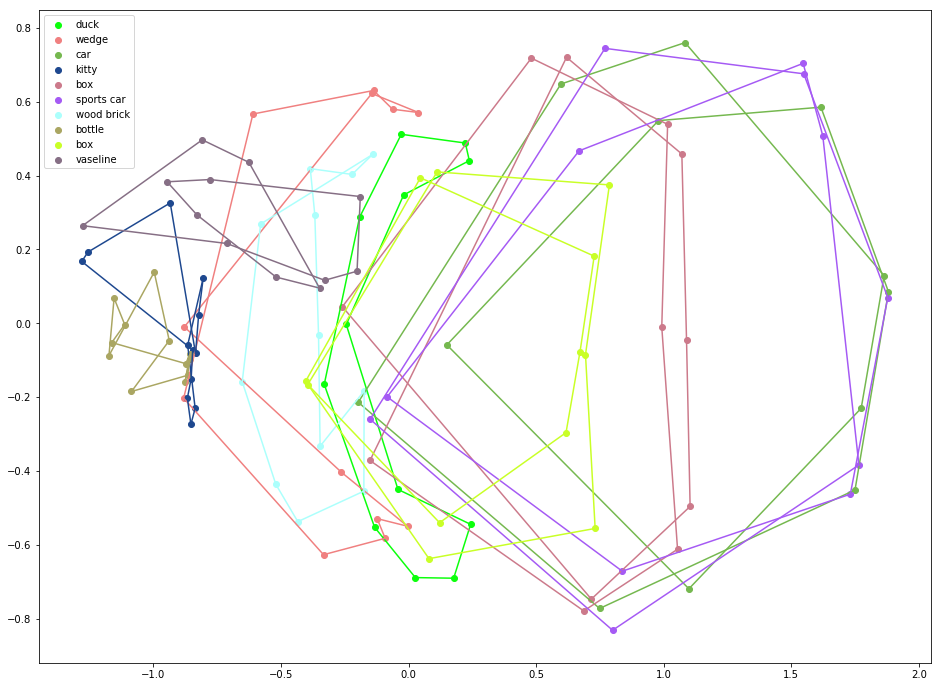

In [15]:
plt.figure(figsize=(16, 12))

rotation_trajectories_scatterplot(imgs_isomap, labels, label_names)
plt.show()

## Local Tangent Space Alignment (LTSA)

In [16]:
from megaman.embedding import LTSA

geom = Geometry(adjacency_kwds=dict(n_neighbors=10))
ltsa = LTSA(radius=0.95)#, geom=geom)

imgs_ltsa = ltsa.fit_transform(imgs)

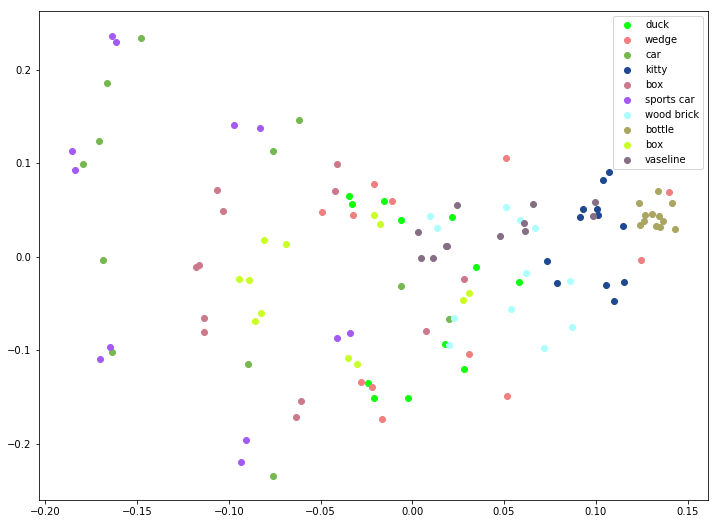

In [17]:
plt.figure(figsize=(12, 9))

signed_scatterplot(imgs_ltsa, labels, label_names)
plt.show()

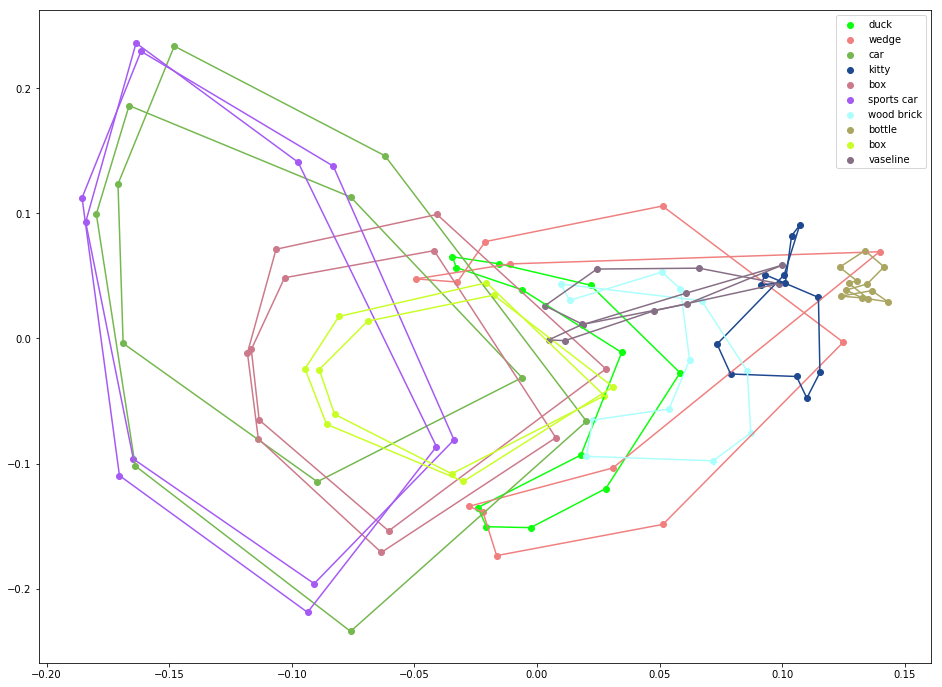

In [18]:
plt.figure(figsize=(16, 12))

rotation_trajectories_scatterplot(imgs_ltsa, labels, label_names)
plt.show()